<h1>Fire Weather Detector</h1>

<h2>Problem Setting</h2>

<b>Description</b>

Montesinho is a natural park in northeastern Portugal. It is home to rare species of plants and animals, attracting tourists by its picturesque views and convenient hiking trails. Unfortunately, the park is subject to frequent wildfires due to its location in the Mediterranean continental climate and other specific factors.

<b>Importance</b>

Wildfires threaten the unqiue flora and fauna of the park, which may be irreversibly lost in a particularly big fire. Thus, timely notifying the park fire team about potentially large wildfires is paramount. Solving this problem is even more important in light of ongoing climate change, as summers become increasingly hotter every year.

<b>Stakeholders</b> 

The direct stakeholders are the park administration and the municipalities of Vinhais and Bragança where the park is located. However, popularity of Montesinho among tourists makes millions of people both in Portugal and worldwide stakeholders of the project.

<b>Method Justification</b>

Machine learning offers a cost-effective solution, relying on data collected from inexpensive weather sensors instead of expensive aerial or space imaging.

<b>Success criteria</b> 

The problem of predicting the area of a wildfire is a regression problem. Due to its ability to magnify large errors and its interpretability, <i>mean squared error</i> will be used to measure the error of each particular model. 

As a benchmark, a simple mean-based model will be introduced. A more advanced model will be considered successful if its mean squared error will be <i>at least twice lower</i> than that of the benchmark. This criterion was chosen after examining successful machine learning projects addressing similar problems.

<b>Data Source</b>

The dataset has been provided by the park administration. It was collected from weather sensors in different points in the park from January 2000 to December 2003. Each observation corresponds to a wildfire of a certain size. 

Although the data can be outdated in some aspects, the underlying natural processes leading to wildfires could not have changed substantially.

<h2>Data Analysis & Visualisation</h2>

The goal of this part is to gain general understanding of the given data, its distributions, interdependencies and correlations. These will affect the choice of prerpocessing and, consequently, models and evaluation. Additionaly, I seek to better understand the underlying natural process of wildfire emergence to have more substantiated intuitions for model design.

First, I will import the necessary libraries for data processing and visualisation:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<ipython-input-2-b478a6fd18e5>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Now, I will upload the csv file provided by the client into a pandas dataframe:

In [3]:
df = pd.read_csv("fires.csv")

Let's see what the columns are:

In [4]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


<b>Feature Meanings</b>

Let's analyse the meaning of each column (feature):

"X" - the location of the wildfire by the x axis.

"Y" - the location of the wildfire by the y axis.

"month" - month when the wildfire occurred.

"day" - day of the week when the wildfire occurred.

"FFMC" - the Fine Fuel Moisture Code of the Fire-Wheather-Index system (see below). It estimates the moisture content of fine surface fuels, such as leaves, needles, and small twigs, which are typically less than 1 cm in diameter. These fine fuels are the most prone to ignition and are critical in the early stages of fire spread. Low FFMC indicates moist fine fuels, which are less likely to ignite. High FFMC suggests dry fine fuels that can ignite easily, contributing to rapid fire spread. While caclulation of FFMC is complex, in the description of the system it is said that FFMC is influenced by <i>temperature, relative humidity, wind, and the amount of rainfall</i>.

"DMC" - the Duff Moisure Code of the Fire-Wheather-Index system. It represents the moisture content of loosely compacted organic layers (duff) below the fine surface fuels. These layers consist of partially decomposed organic matter, such as needles, leaves, and humus, which accumulate on the forest floor. Low DMC indicates moist conditions in the duff layer, reducing the likelihood of sustained burning. High DMC reflects dry conditions, where the duff layer can sustain and contribute to fire intensity. The system's description says that calculation of DMC is influenced by <i>the amount of rainfall, relative humidity and temperature</i>.

"DC" - the Drought code of the Fire-Wheather-Index system. It is a long-term index that represents the moisture content of deep, compact organic layers, such as deep humus or compacted peat. It reflects the cumulative effects of seasonal drought conditions. Low DC indicates wetter conditions in deep organic layers, which are less likely to support deep-seated fires. High DC suggests severe dryness, where deep organic layers can support persistent and intense fires, even under less severe surface weather conditions. It is said to be influenced by <i>the amount of rainfall and temperature</i>.

"ISI" - the Initial Spread Index of the Fire-Wheather-Index system. It is a numerical rating that predicts the expected rate of fire spread immediately after ignition. It combines the effects of wind speed and the FFMC to estimate how quickly a fire might spread in its early stages. Low ISI suggests slow fire spread, typically under calm or moist conditions. High ISI indicates rapid fire spread, usually under dry and windy conditions. It is said to be influenced by <i>the wind speed and FFMC</i>.

"temp" - the temperature in degrees Celsius on the day when the wildfire occurred.

"RH" - relative humidity in percentage.

"wind" - wind velocity in km/h.

"rain" - the amount of rain in mm / m2.

"area" - the forest area that has been burnt in hectares.

<b>Canadian Forest Fire Weather Index System</b>
    <img src="https://fs-prod-nwcg.s3.us-gov-west-1.amazonaws.com/s3fs-public/2023-11/437-cffdrs-overview-fwi-flowchart.png?VersionId=9JAIgcLo1ABRBfMkqvwa8SEAqLCWknXC" 
         alt="FWI Flowchart" 
         width="500" 
         height="300" 
         title="FWI Flowchart Overview">
    <p>This image provides an overview of feature interactions according to the Canadian FWI System.</p>

<b>Conclusions<b/>

1. There are two categorical features that must be converted using 1 hot vectors.

2. Four features (FFMC, DMC, DC, ISI) are <i>dependent</i> on other features (rain, temperature, RH, wind) and each other (ISI and FFMC). This may create redundancy of training information and necessitate feature selection.

<b>Feature Ranges</b>

It is also important to analyse feature ranges, since it will have implications on data processing: if they are very different, the proper performance of most models will require scaling/normalizing these features to the same range.

Analysing ranges might also give me deeper understanding of the underlying natural process.

In [5]:
for column in df.columns:
    print(f"\nRange of the '{column}' column is from { df[column].min()} to {df[column].max()}")


Range of the 'X' column is from 1 to 9

Range of the 'Y' column is from 2 to 9

Range of the 'month' column is from apr to sep

Range of the 'day' column is from fri to wed

Range of the 'FFMC' column is from 18.7 to 96.2

Range of the 'DMC' column is from 1.1 to 291.3

Range of the 'DC' column is from 7.9 to 860.6

Range of the 'ISI' column is from 0.0 to 56.1

Range of the 'temp' column is from 2.2 to 33.3

Range of the 'RH' column is from 15 to 100

Range of the 'wind' column is from 0.4 to 9.4

Range of the 'rain' column is from 0.0 to 6.4

Range of the 'area' column is from 0.0 to 1090.84


Let's analyse the ranges:

1. Spatial coordinates X and Y lie in a relatively small range, which indicates that the target area is rather compact.

2. "month" and "day" features are categorical, which implies preprocessing using 1-hot vectors. Their ranges cover a full year and a full week, which indicates that wildfires occured in every month of a year and on every day of a week.

3. FFMC's range indicates that there are areas with extremely wet fine fuel (18.7) and extremely dry fine fuel (96.2)

4. DMC's range indicates that there are areas with extremely moist duff layer (1.1) and extremely dry duff layer (291.3)

5. DC's range shows a significant variation in long-term drought conditions, from relatively wet (7.9) to extremely dry (860.6). The high upper value (860.6) indicates areas that experienced severe drought, which makes them prone to intense and long-lasting fires.

6. ISI's range indicates very different potential for fire spread, from no spread (0.0) to very rapid spread (56.1).

7. The temperature range shows a wide variety of weather conditions, from relatively cold (2.2°C) to hot (33.3°C).

8. The relative humidity range shows conditions from very dry (15%) to completely humid (100%).

9. The wind speed range varies from almost still (0.4 km/h) to moderately strong winds (9.4 km/h).

10. The rainfall range indicates conditions from no rain (0.0 mm) to a moderate rain (6.4 mm) (it is worth noticing that no heavy rains are listed in the data, which may evidence that a rain stronger that 6.4 mm may completely block the development of wildfire).

11. The range of burned area shows that a fire size varies greatly, from no area burned (0.0 ha) to a very large area burnt (1090.84 ha).

<b>Conclusions</b>:

All the features demonstrate wide ranges of values. This indicates a great variety of conditions in the target territory. In terms of data prerpocessing, it indicates the need to normalize/scale the features, which is necessary for many ML models to perform well.

<b>Feature Distributions</b>

Analysing feature distributions is crucial for choosing the appropriate data preprocessing techniques. In order to understand what distribution (normal, uniform, skewed, multimodal etc) each feature follows, I will visualise the distributions:

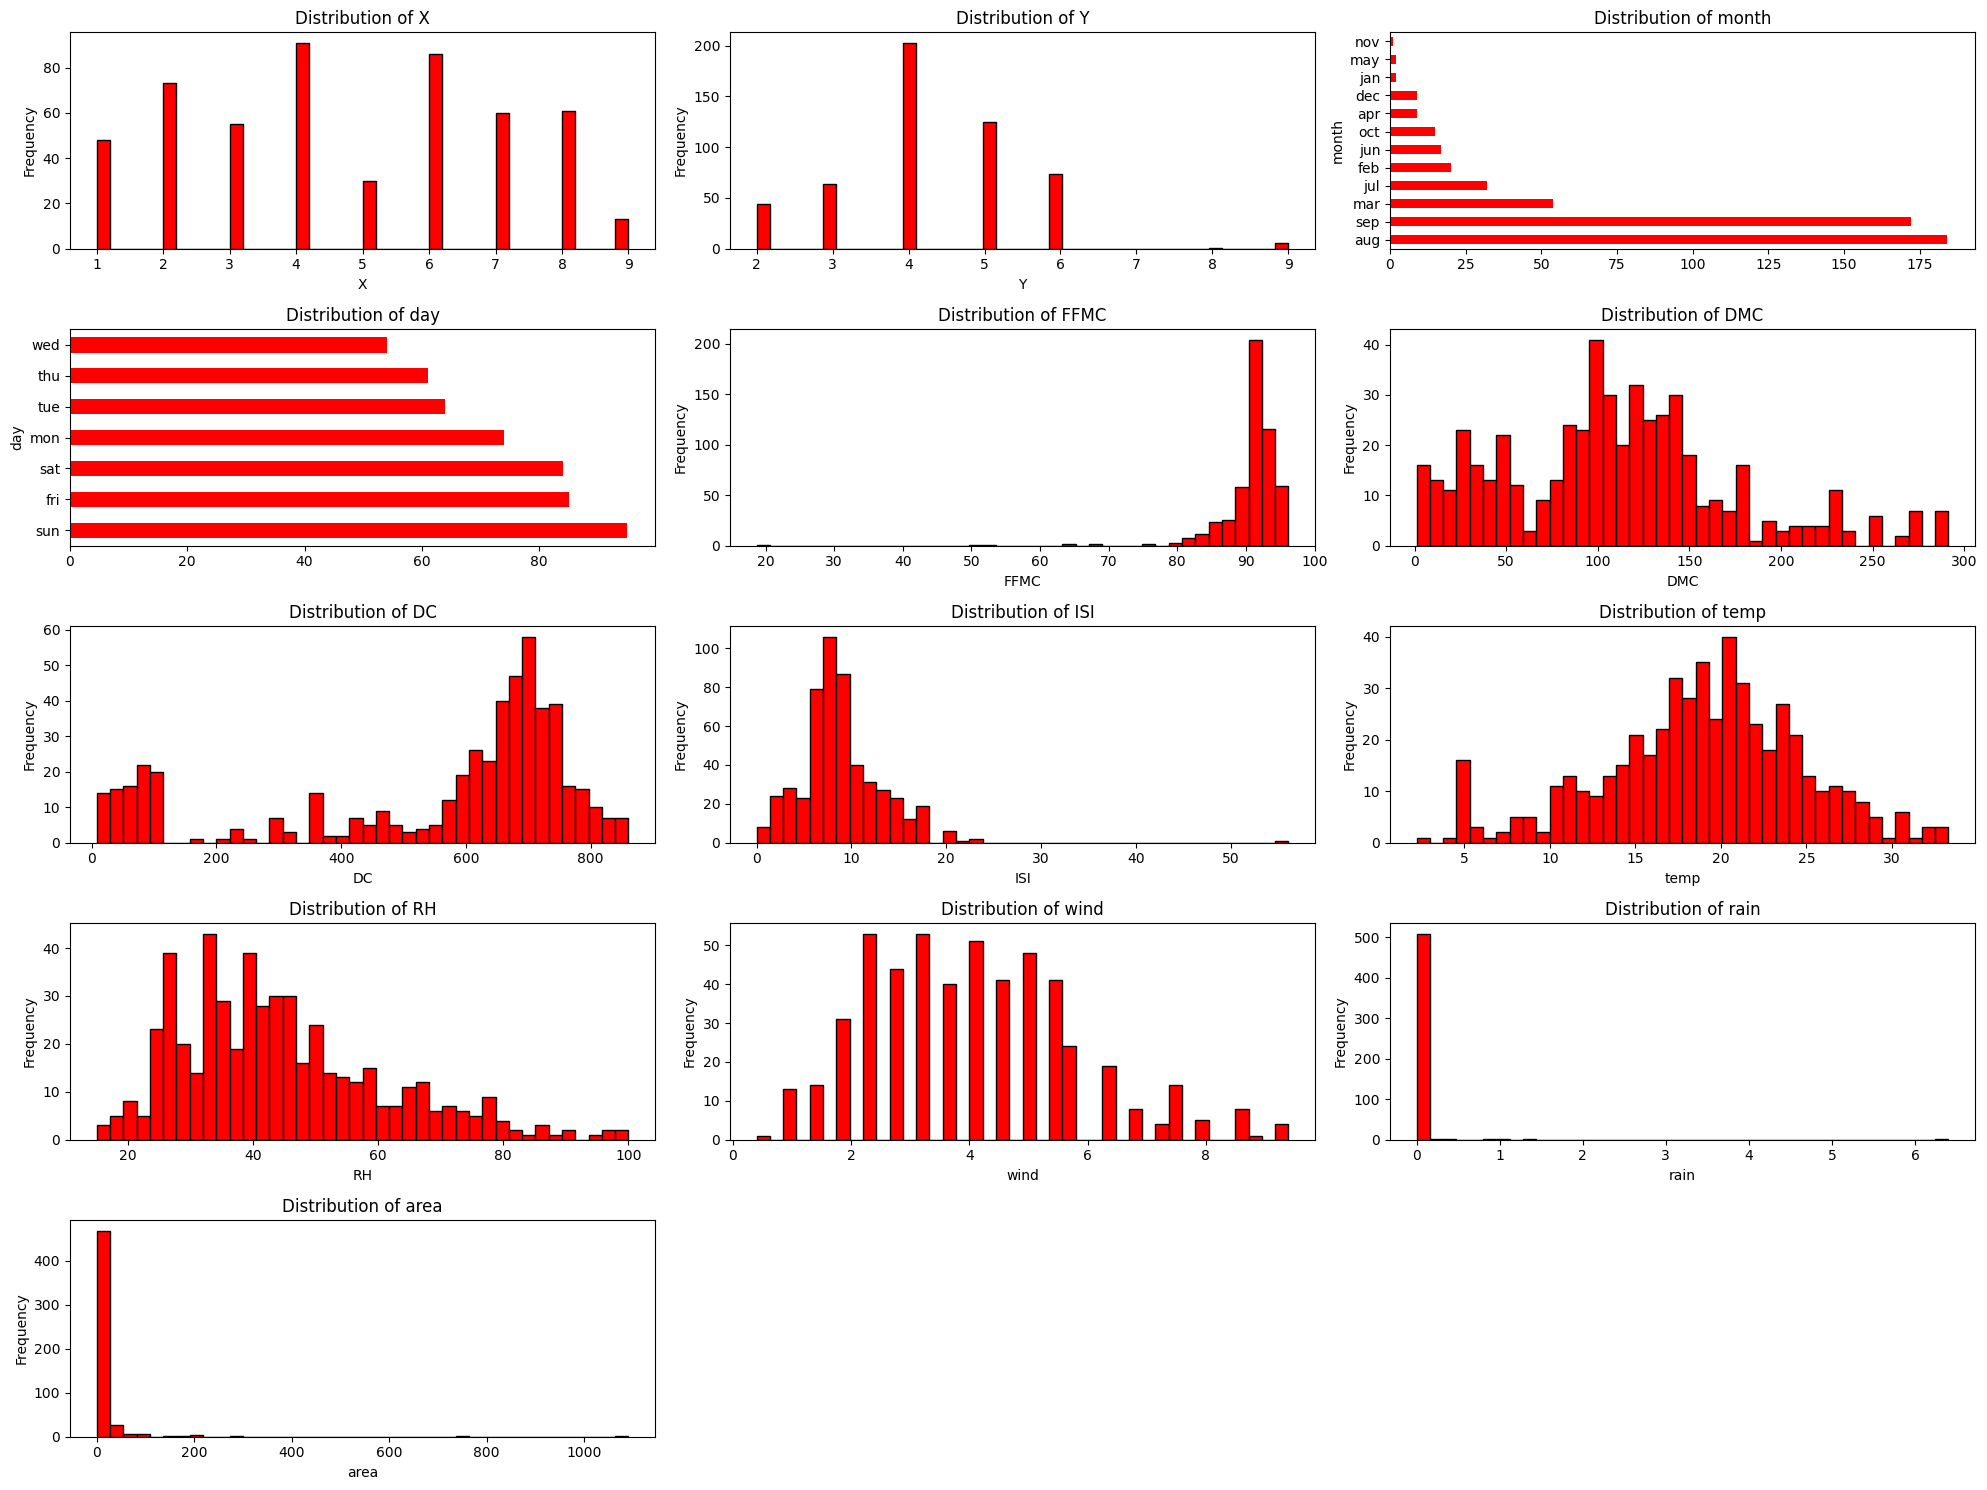

In [6]:
plt.figure(figsize=(20, 15))

for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns) // 3 + 1, 3, i + 1)
    
    if df[column].dtype == object or df[column].nunique() < 10 and not "rain":
        df[column].value_counts().plot(kind='barh', color = 'red')
        plt.title(f'Distribution of {column}')
    else:
        plt.hist(df[column].dropna(), bins=40, color = 'red', edgecolor='black')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
plt.tight_layout()

plt.show()

<b>Analysis</b>

"X" - roughly uniform

"Y" - roughly uniform

"month" -  'seasonal' distribution peaking in August

"day" - roughly uniform

"FFMC" - heavily left-skewed distribution, indicating that fine fuels are often dry and flammable

"DMC" - moderately right-skewed bimodal distribution, which indicates abundance of conditions with a very wet and a moderately dry duff layer

"DC" - left-skewed bimodal distribution, which indicates a big number of both wet (left clump) and dry (right clump) deep organic layers

"ISI" - heavily right-skewed, peaking at lower values and with a long tail towards higher values; this indicates prevalence of slow fire-spread

"temp" - roughly normal, which means that temperatures gravited towards the mean value when fires were observed

"RH" - moderately right-skewed, tending towards a normal one, which indicates a bigger number of conditions with low relative humidity

"wind" - roughly normal

"rain" - heavily right-skewed, with most values being 0, which indicates absolute prevalence of dry weather

"area" (target attribute) - heavily right-skewed, with most instances showing small areas burned and a few outliers with significantly larger areas

<b>Conclusions for Data Processing</b>

Given the observed distributions, I would suggest the following pre-processing for different groups of features:

1. Logarithmic scaling for all columns with heavily skewed distributions: "area", "rain", "ISI", "FFMC"

2. Z-score normalisation for all columns with roughly normal distributions: "temp", "RH", "wind"

3. Min-max scaling for all columns with roughly uniform and bimodal distributions: "X", "Y", "DMC",  "DC"

4. 1-hot encoding for categorical columns: "day", "month"

<b>Relation To The Target Attribute</b>

I will now visualise some of the features in their correlation with the target attribute of fire area to better understand the underlying natural processes, possibly identify key predictors and spot outliers.

<b>Location vs Fire Size</b>

First, I will visualise geographical distribution of wildfires in the park. I will use "X" and "Y" columns to locate fires and the "area" column to determine their sizes. I will represent the area of each fire by the size of the blob at a certain coordinate. Transparency of the blobs will also allow me to roughly estimate the frequency of wildfires in different locations.

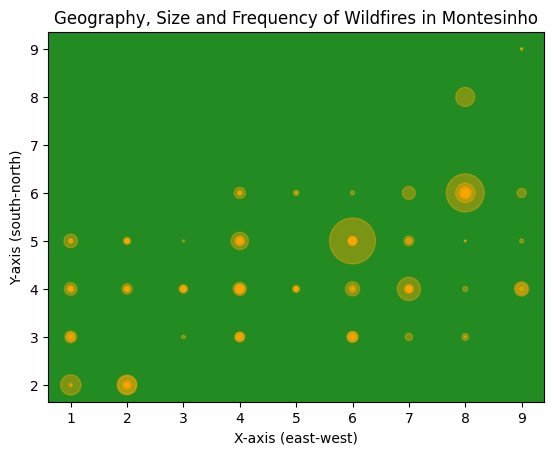

In [7]:
fig, ax = plt.subplots()
ax.set_facecolor('forestgreen')
ax.scatter(df['X'], df['Y'], s=df['area'], color='orange', alpha=0.4)

ax.set_xlabel('X-axis (east-west)')
ax.set_ylabel('Y-axis (south-north)')
ax.set_title('Geography, Size and Frequency of Wildfires in Montesinho')

plt.show()

<b>Conclusions</b>

1. There are no noticeable wildfires in the north-western part of the park, which may indicate fire-safe conditions like constantly high humidity of soils.

2. The biggest density of wildfires is around the central latitude (Y = 4).

3. The places where the biggest wildfires happened are also places where they happen frequently.

4. Overall, the possibility of a wildfire is obviously dependent on a location.

<b>Month vs Fire Size</b>

Now I will look at the distribution of wildfires by months. I have an assumption that summer months and September are more prone to largest wildfires than the rest of the year.

Although the correlation between fire frequency and the month does not include the target variable, it might be useful to also look at it to better understand the underlying natural process. My assumption is that this correlation will roughly match the one between fire area and the month:

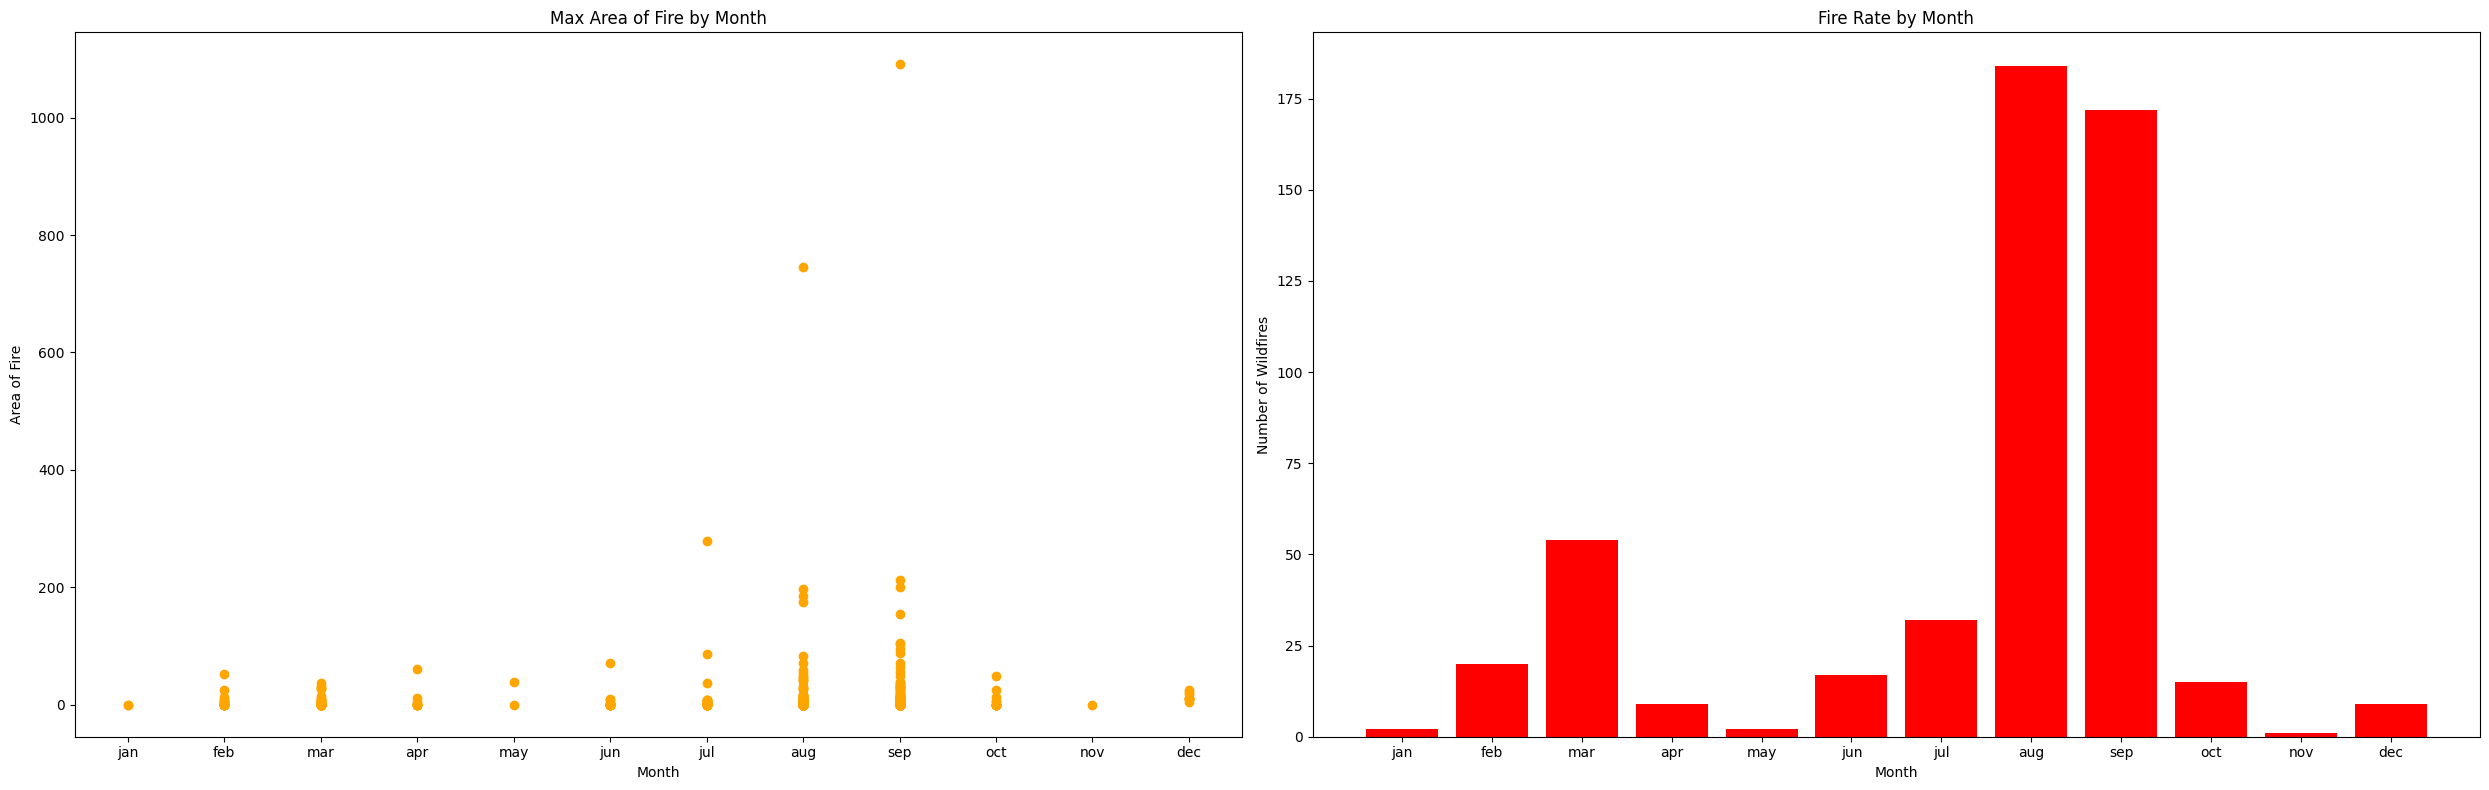

In [8]:
months_sorting_dict = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4,
    "may": 5, "jun": 6, "jul": 7, "aug": 8,
    "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

df["month"] = df["month"].map(months_sorting_dict)
df = df.sort_values('month')

months_map_back = {key: value for value, key in months_sorting_dict.items()}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))

ax1.scatter(df['month'].map(months_map_back), df['area'], color='orange')
ax1.set_xlabel('Month')
ax1.set_ylabel('Area of Fire')
ax1.set_title('Max Area of Fire by Month')

months_count = df['month'].value_counts().to_dict()
months_count = {k: months_count[k] for k in sorted(months_count)}
months_count = {key: value for key, value in zip(months_sorting_dict.keys(), months_count.values())}

ax2.bar(months_count.keys(), months_count.values(), color='red')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Wildfires')
ax2.set_title('Fire Rate by Month')

plt.tight_layout()
plt.show()

<b>Conclusions</b>

1. Wildfires with the biggest area happen in September, which confirms my assumption: dried layers of soil create the most favourable conditions for wildfires after a few months of hot dry weather.
   
2. The area of wildfires starts to increase almost exponentially from June.
   
3. There are no or almost no noticeable wildfires in January and November.

4. The area of wildfires from February to May is relatively small and roughly the same.

5. The area of wildfires rapidly drops after September, which may be due a sharp increase in humidity.

6. The number of fires is roughly proportional to the area of the biggest fire in 
the given month, which confirms my assumption.

7. While the number of fires peaks in August, the biggest one happens in September, which indicates the importance of continuous drought.
   
8. While the max area of a fire in March is smaller than that in February and April, the number of fires in March is almost thrice bigger than in these other two months.

7. November is the safest month both by the number and the area of fires.

<b>Day of the week vs Fire Area</b>

My assumption is that there must be a correlation between the fire area / frequency of fires and whether the day is a weekday or weekend: human factor is a common cause of wildfires, and the number of tourists in the park is expected to be higher on weekends than on weekdays.

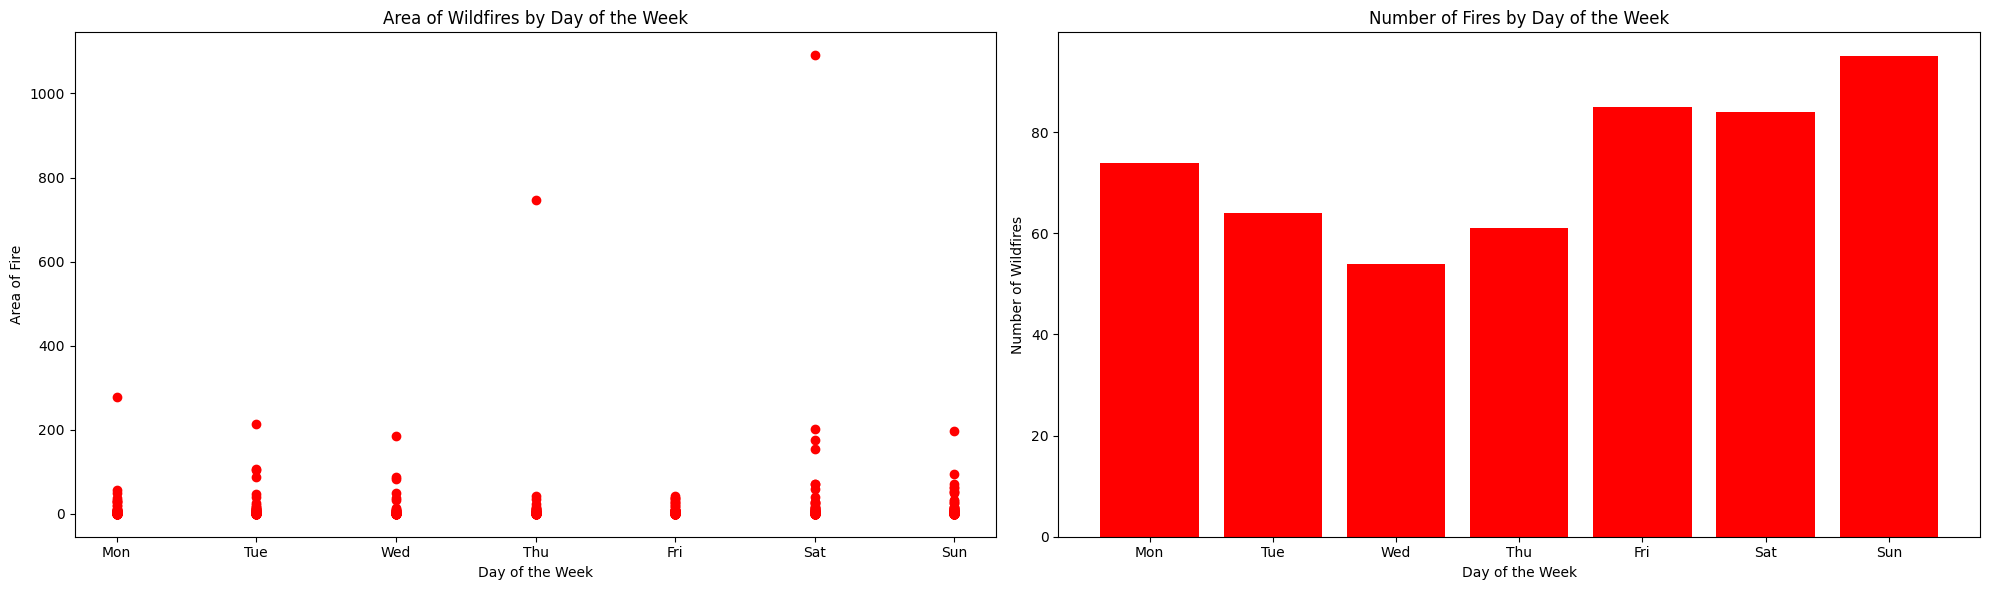

In [9]:
days_sorting_dict = {
    "mon": 1, "tue": 2, "wed": 3, "thu": 4,
    "fri": 5, "sat": 6, "sun": 7
}


df["day_num"] = df["day"].map(days_sorting_dict)

df = df.sort_values('day_num')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.scatter(df['day_num'], df['area'], color='red')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Area of Fire')
ax1.set_title('Area of Wildfires by Day of the Week')
ax1.set_xticks(list(days_sorting_dict.values()))
ax1.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

days_count = df['day'].value_counts().sort_index().to_dict()

days_count_ordered = {k: days_count.get(k, 0) for k in days_sorting_dict.keys()}

ax2.bar(days_count_ordered.keys(), days_count_ordered.values(), color='red')
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Number of Wildfires')
ax2.set_title('Number of Fires by Day of the Week')
ax2.set_xticks(list(days_sorting_dict.keys()))
ax2.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

plt.tight_layout()

plt.show()

<b>Conclusions</b>

1. The area of fires has two major outliers: on Saturday (which may be due to tourist activity) and on Thursday (which contradicts my assumption in regard to fire area).

2. The number of fires is noticeably higher on weekends, peaking on Sunday, which confirms my assumption in regard to frequency of fires.

<b>Wind Speed / Relative Humidity / Rainfall vs Fire Area</b>

My intuition about the correlation between wind speed and fire area is that they are positively correlated. My assumption is that relative humidity negatively correlates with fire area and that temperature will positively correlate with fire area.

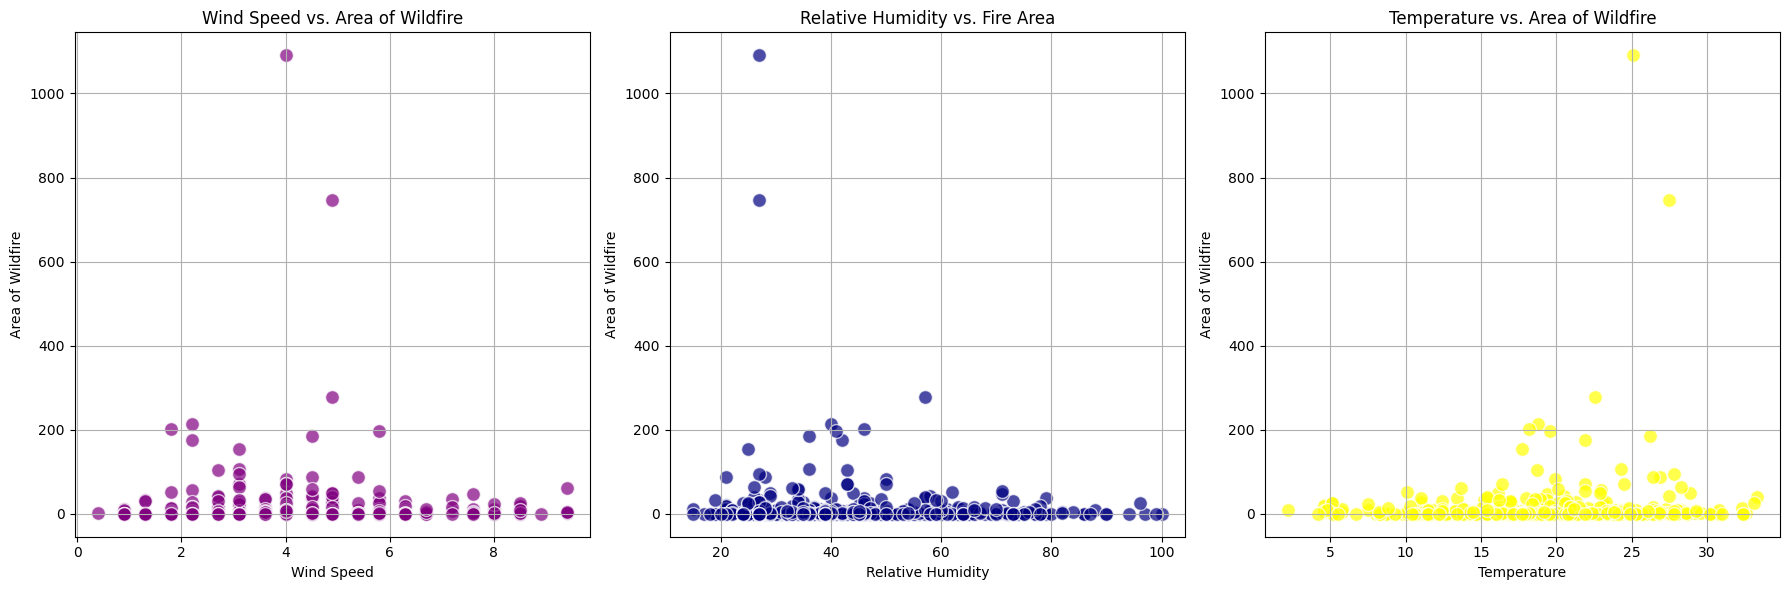

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(df['wind'], df['area'], alpha=0.7, c='purple', edgecolors='w', s=100, marker='o')
axes[0].set_xlabel('Wind Speed')
axes[0].set_ylabel('Area of Wildfire')
axes[0].set_title('Wind Speed vs. Area of Wildfire')
axes[0].grid(True)

axes[1].scatter(df['RH'], df['area'], alpha=0.7, c='navy', edgecolors='w', s=100, marker='o')
axes[1].set_xlabel('Relative Humidity')
axes[1].set_ylabel('Area of Wildfire')
axes[1].set_title('Relative Humidity vs. Fire Area')
axes[1].grid(True)

axes[2].scatter(df['temp'], df['area'], alpha=0.7, c='yellow', edgecolors='w', s=100, marker='o')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Area of Wildfire')
axes[2].set_title('Temperature vs. Area of Wildfire')
axes[2].grid(True)

plt.tight_layout()
plt.show()

<b>Conclusions</b>

1. Contrary to my intuition, the biggest wildfires didn't happen at the fastest wind, but when the wind was in mid range or even smaller.

2. The smallest wildfires happened at any windspeed nondiscriminatingly.
 
3. The wind speed range most favourable for larger wildfries is between 2 and 6 km/hour.

4. The biggest wildfires happened when the relative humidity was around 25%.

3. All the noticeable wildfires happened when the relative humidity is below 60%.
   
5. Noticeable wildfires doesn't happened and any wildifires become very rare when the relative
humidity is higher than 80%.

6. Biggest wildfires happen at temperatures closer to the higher end of the range: 25-27 dgrs.
   
7. Noticeable wildfires start to happen when the temperature exceeds 15 degrees.
   
8. There are almost no wildfires at all in the range between 0 and 5 degrees.

<b>Fire-Weather Index System Codes vs Fire Area</b>

While Fire-Weather System's codes are strongly influenced by the already considered features, they also represent soil conditions that may be predictive of the fire area. The simple assumption is that dryness of soils will positively correlate 

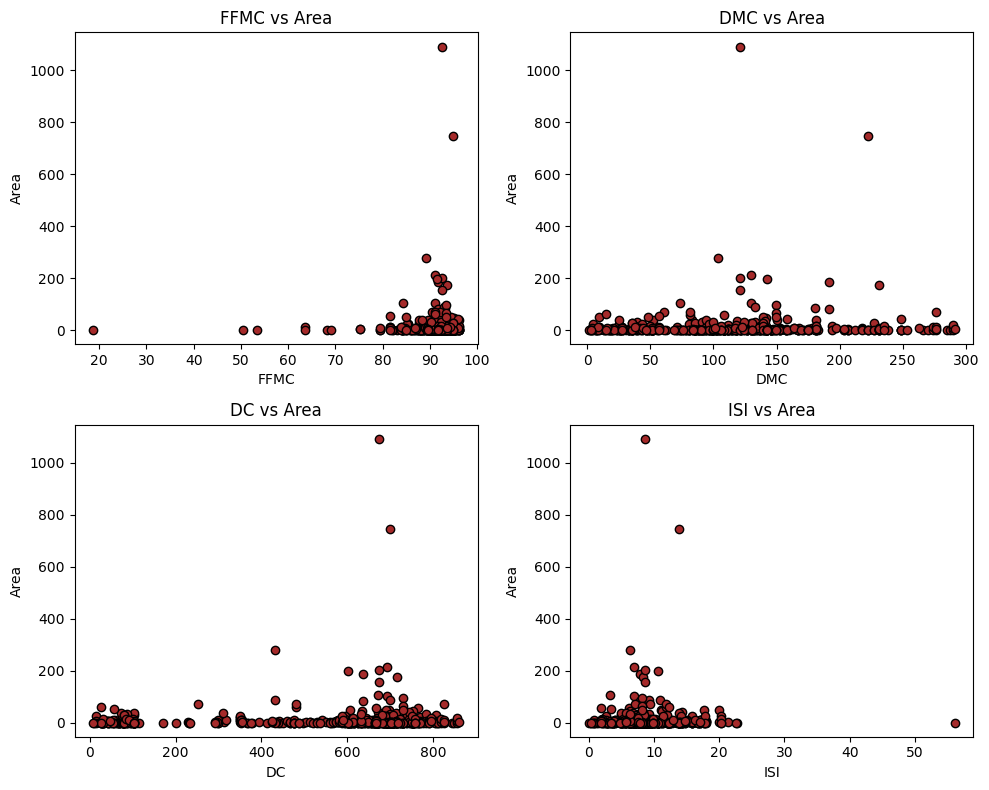

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(df['FFMC'], df['area'], c="brown", edgecolors='black')
axes[0, 0].set_title('FFMC vs Area')
axes[0, 0].set_xlabel('FFMC')
axes[0, 0].set_ylabel('Area')

axes[0, 1].scatter(df['DMC'], df['area'], c="brown", edgecolors='black')
axes[0, 1].set_title('DMC vs Area')
axes[0, 1].set_xlabel('DMC')
axes[0, 1].set_ylabel('Area')

axes[1, 0].scatter(df['DC'], df['area'], c="brown", edgecolors='black')
axes[1, 0].set_title('DC vs Area')
axes[1, 0].set_xlabel('DC')
axes[1, 0].set_ylabel('Area')

axes[1, 1].scatter(df['ISI'], df['area'], c="brown", edgecolors='black')
axes[1, 1].set_title('ISI vs Area')
axes[1, 1].set_xlabel('ISI')
axes[1, 1].set_ylabel('Area')

plt.tight_layout()
plt.show()

<b>Conclusions</b>

1. FFMC (fine fuel moisture) vs fire area - I see that absolutely most fires, including the biggest ones, happened when fine fuel was dry. However, there is a small fire outlier that happened with very wet fine fuel.

2. DMC (duff layer moisture) vs fire area - I see that wildfires happened with almost any value of duff moisture, bigger ones and outliers taking place in range between 100 and 250.

3. DC (drought code) vs fire area - I see that many smaller wildfires happened when deep layers of soil were very wet (left end), any fires rarely happened in DC range between approximately 100 to 300, and most wildfires, including the biggest ones, happened in drier deep layers condition with DC from 350 to 850.

4. ISI (initial fire spread) vs fire area - surprisinlgly, most wildfires, including the biggest ones, happened at a relatively low initial fire spread, with one small outlier happenning at a high ISI. This may indicate that ISI is only important for ignition and initial stage of wire, but not the area it will ultimately take.

5. Speaking of all the four FWI system's codes, I must notice their non-linear relationship with the target attribute.

<b>General Conclusions from Data Analysis & Visualisation Part</b>

1. Features demonstrate different distibutions and will require different processing.

2. Features have different ranges, and squeezing them to similar ranges might be crucial for many models.

2. There is no single "best" predictor for the target attribute, so no features can be dropped at this stage.

3. Outliers (particularly large fires) mostly correspond to bigger density of fires in general against a certain condition, so I will not consider them errors in the data.

<h2>Data Preprocessing</h2>

<b>Handling Missing Values</b>

The first step is to check the quality of the provided dataset, namely whether it contains missing values. It it does, I will need to process them accordingly:

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

X          0
Y          0
month      0
day        0
FFMC       0
DMC        0
DC         0
ISI        0
temp       0
RH         0
wind       0
rain       0
area       0
day_num    0
dtype: int64


As I see, the dataset does not contain any missing values.

<b>Normalization/Scaling</b>

Drawing upon the conclusions made in the Data Analysis & Visualisation part, I will apply the necessary preprocessing to each feature:

Min-Max scaling: "X", "Y", "DC", "wind", 'ISI', 'DMC'

Logarithmic transformation: 'area', 'rain'

Z-score normalisation: "FFMC", "RH", "temp"

One-hot encoding: "month", "day"

To preprocess the features as required, I will implement a range of functions:

In [13]:
def min_max_norm(column):
    min_value = column.min()
    max_value = column.max()
    normalized_column = (column - min_value) / (max_value - min_value)
    return normalized_column


def log_transform(feature):
    feature = np.array(feature)
    return np.log1p(feature)


def z_score_norm(column):
    mean = column.mean()
    std = column.std()
    normalized_column = (column - mean) / std
    return normalized_column

And apply them to the target columns:

1. Logarithmic scaling for all columns with heavily skewed distributions: "area", "rain", "ISI", "FFMC"

2. Z-score normalisation for all columns with roughly normal distributions: "temp", "RH", "wind"

3. Min-max scaling for all columns with roughly uniform and bimodal distributions: "X", "Y", "DMC",  "DC"

4. 1-hot encoding for categorical columns: "day", "month"

In [14]:
preprocessed_df = pd.read_csv("fires.csv")

scaling_options = {"Min Max Norm":["X", "Y", "DMC",  "DC",],
                    "Log Transformation":['area', 'rain', "FFMC", "ISI"],
                    "Z-score":["temp", "RH", "wind"],
                    "One-hot":["month", "day"]}

for column in df.columns:
    if column in scaling_options["Min Max Norm"]:
        preprocessed_df[column] = min_max_norm(preprocessed_df[column])
    elif column in scaling_options["Log Transformation"]:
        preprocessed_df[column] = log_transform(preprocessed_df[column])
    elif column in scaling_options["Z-score"]:
        preprocessed_df[column] = z_score_norm(preprocessed_df[column])
    
preprocessed_df = pd.get_dummies(preprocessed_df, columns=scaling_options["One-hot"], dtype=int)

Let's see if the applied preprocessing has brought the expected results:

In [15]:
preprocessed_df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0.750,0.428571,4.468204,0.086492,0.101325,1.808289,-1.840857,0.411326,1.497164,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,0.750,0.285714,4.517431,0.118194,0.775419,2.041220,-0.153130,-0.691786,-1.740070,0.000000,...,0,1,0,0,0,0,0,0,1,0
2,0.750,0.285714,4.517431,0.146795,0.796294,2.041220,-0.738668,-0.691786,-1.516813,0.000000,...,0,1,0,0,0,1,0,0,0,0
3,0.875,0.571429,4.529368,0.110958,0.081623,2.302585,-1.823636,3.230391,-0.009824,0.182322,...,0,0,0,1,0,0,0,0,0,0
4,0.875,0.571429,4.503137,0.172984,0.110590,2.360854,-1.289763,3.352959,-1.237741,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.375,0.142857,4.414010,0.191592,0.771315,1.064711,1.534597,-0.753070,-0.735411,0.000000,...,0,0,0,0,0,0,1,0,0,0
513,0.125,0.285714,4.414010,0.191592,0.771315,1.064711,0.518517,1.637006,0.994835,0.000000,...,0,0,0,0,0,0,1,0,0,0
514,0.750,0.285714,4.414010,0.191592,0.771315,1.064711,0.397965,1.575722,1.497164,0.000000,...,0,0,0,0,0,0,1,0,0,0
515,0.000,0.285714,4.558079,0.499311,0.711622,2.509599,1.155720,-0.140230,-0.009824,0.000000,...,0,0,0,0,0,1,0,0,0,0


<h2>Models</h2>

In this part, I will implement a range of machine learning models to deal with the problem at hand. Since I have no prior assumptions about which model will perform better and relationships between the features seem complex, I will start with simpler, linear models and then go towards more complex, non-linear ones.

My task is to build a system that will predict a continuous target attribute when given unseen data drawn from the same distribution as the training data. This requires a <b>regression</b> model.

I am going to take an object-oriented approach to model creation, so I will first create a parent class to make sure that all my models have a standardised interface for future hyperparameter tuning:

In [16]:
class Model(object):
    
    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key) == True:
                setattr(self, key, value)
            else:
                raise ValueError(f"Parameter {key} is not valid for this model.")
        return self

I will also need a simple metric to evaluate my models at development time:

In [17]:
def mean_squared_error(y_hat, y_true):
    return ((y_hat - y_true) ** 2).sum() / len(y_hat)

And import a function to split the dataset into training and test set:

In [18]:
from sklearn.model_selection import train_test_split

X = preprocessed_df.drop(columns=["area"])
y = preprocessed_df["area"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Before I implement anything complex, I will create the simplest model to be used as a benchmark for more complex ones.

<b>Baseline Regression</b>

My simplest model will calculate the mean of the training set, add Gaussian noise and then use this value to "predict" the target attribute on the training set.

In [19]:
class BaselineRegression(Model):

    def __init__(self, noise_std=0.1):
        self.noise_std = noise_std
        self.mean = None
        
    def fit(self, X_train, y_train):
        self.mean = np.mean(y_train)
        
    def predict(self, X_test):
        preds = np.full(len(X_test), self.mean)
        preds += np.random.normal(0, self.noise_std, len(X_test))
        return preds

Let's check if the baseline model works and how it performs on the training set:

In [20]:
clf0 = BaselineRegression()
clf0.fit(X_train, y_train)
clf0_preds = clf0.predict(X_test)
mean_squared_error(clf0_preds, y_test)

2.2064221384551184

Given the mean (1.11) of the dataset, the baseline model performs just a expected - it randomly "guesses" around the mean.

Now, I will implement more advanced regression models to compare them against this benchmark.

<b>Ridge Regression</b>

Ridge regression is a linear regression model that utilises the L2 regulariser (square of the parameter vector aka squared Euclidian norm) to prevent overfitting by making the learning coefficients smaller.

Ridge Regression has a closed-form analytic solution for smaller datasets, which allows me to avoid using optimisation methods like gradient descent.

In [21]:
class MyRidgeRegression(Model):

    def __init__(self, offset = True, reg_strength = 0.1):
        self.offset = offset
        self.reg_strength = reg_strength
        self.theta = None

    def fit(self, X_train, y_train):
        if self.offset == True:
            X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        else:
            None
        XTX = np.dot(X_train.T, X_train)
        lambdaI = self.reg_strength * np.identity(XTX.shape[0])
        XTy = np.dot(X_train.T, y_train)
        XtX_plus_lambdaI_inverse = np.linalg.inv(XTX + lambdaI)
        self.theta = np.dot (XtX_plus_lambdaI_inverse, XTy)
        return self

    def predict(self, X_test):
        if self.offset == True:
            X_test_with_offset = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
            preds = np.dot(X_test_with_offset, self.theta)
        else:
            preds = np.dot(X_test, self.theta)
        return preds

Let's check if my regression model works and how it performs on hold-out testing:

In [22]:
clf1 = MyRidgeRegression(reg_strength=0.1)
clf1.fit(X_train, y_train)
clf1_preds= clf1.predict(X_test)
mean_squared_error(clf1_preds, y_test)

2.2717460229432413

It works and performs worse than random guessing around the mean (Baseline Model). This may be due to a small training set or the fact that L2 regularisation does not address the problem of overfitting on the given dataset.

*I must notice here that hold-out risk evaluation is <b>not</b> final and only done at development time. The final evaluation of all models will be done through nested cross-validation.

<b>Lasso Regression</b>

Lasso regression uses the L1 regularizer, which is the sum of absolute values of parameters (aka Manhatten norm). My motivation to use it that it addresses potential feature redundancy effectively, making the feature space sparse.

Unlike the ridge regression, it does not have a closed-form solution, which necessitates an iterative optimisation algorithm like gradient descent.

In [61]:
class MyLassoRegression(MyRidgeRegression):

    def __init__(self, reg_strength=1, offset=True, num_epochs=1000, step_size=0.01, epsilon=1e-5):
        self.reg_strength = reg_strength
        self.offset = offset
        self.num_epochs = num_epochs
        self.step_size = step_size
        self.epsilon = epsilon
        self.theta = None

    def fit(self, X_train, y_train):
        if self.offset:
            X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

        num_obs, num_feat = X_train.shape
        self.theta = np.zeros(num_feat)

        for step in range(self.num_epochs):
            y_hat = np.dot(X_train, self.theta)
            residuals = y_hat - y_train
            grad = (1 / num_obs) * np.dot(X_train.T, residuals)

            self.theta -= self.step_size * grad

            self.theta[1:] = np.sign(self.theta[1:]) * np.maximum(0, np.abs(self.theta[1:]) - self.step_size * self.reg_strength / num_obs)

            if np.all(np.abs(self.step_size * grad) < self.epsilon):
                print(f"Converged at step {step}")
                break

        return self


Let's see if my lasso regression model works and if it works better than the baseline on hold-out testing:

In [62]:
clf2 = MyLassoRegression(reg_strength=10)
clf2.fit(X_train, y_train)
clf2_preds = clf2.predict(X_test)
mean_squared_error(clf2_preds, y_test)

2.1629917313481153

My lasso regression model works and it performs slightly better than both my baseline and ridge regression models.

<b>Elastic Net Regression</b>                             

Elastic net regression is another model I can use to predict a continuous value (regression problem). The difference with the ridge and lasso regression is that it uses both L2 and L1 regularisation. Just like lasso, it reflects my assumption of feature redundancy, but adds to it a belief that feature coefficients cannot be too large.

Just like lasso regression, elastic net regression does not have a closed-form solution, so I will have to use numerical optimisation like gradient descent:

In [1]:
class MyElasticNet(MyRidgeRegression):

    def __init__(self, reg_strength=0.001, L1_to_L2_ratio=1.0, offset=True, num_epochs=1000, step_size=0.01, epsilon=1e-5):
        if not 0 <= L1_to_L2_ratio <= 1:
            raise ValueError("L1_to_L2_ratio must be between 0 and 1.")
        self.L1_reg_strength = L1_to_L2_ratio * reg_strength
        self.L2_reg_strength = (1 - L1_to_L2_ratio) * reg_strength
        self.offset = offset
        self.num_epochs = num_epochs
        self.step_size = step_size
        self.epsilon = epsilon
        self.theta = None

    def fit(self, X_train, y_train):
        if self.offset:
            X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

        num_obs, num_feat = X_train.shape
        self.theta = np.zeros(num_feat)

        for iteration in range(self.num_epochs):
            y_pred = np.dot(X_train, self.theta)
            residuals = y_pred - y_train

            grad = (1 / num_obs) * np.dot(X_train.T, residuals)

            for i in range(1, num_feat):
                self.theta[i] -= self.step_size * (grad[i] + self.L2_reg_strength * self.theta[i])
                self.theta[i] = np.sign(self.theta[i]) * max(0, abs(self.theta[i]) - self.step_size * self.L1_reg_strength)

            if np.linalg.norm(self.step_size * grad) < self.epsilon:
                print(f"Converged at iteration {iteration + 1}")
                break

        return self


<class 'NameError'>: name 'MyRidgeRegression' is not defined

Let's see if my elastic net regression model works and if it works better than the baseline on hold-out testing:

In [76]:
clf3 = MyElasticNet()
clf3.fit(X_train, y_train)
clf3_preds = clf3.predict(X_test)
mean_squared_error(clf3_preds, y_test)

2.1301912500300344

My elastic net regression model works and performs slightly better than my baseline, ridge and lasso models.

<b>Kernel Ridge Regression</b>

Kernel Ridge Regression is a regression model that uses kernelized training data to make a prediction. Unlike "primal", linear regression models, this model is non-linear and is capable of recognizing complex relationships between features, which I suspect are present in my data.

Given the relatively small size of my dataset, it will be feasible and interesting to implement this model and compare its performance against the "primal" regression models I have implemened. Just like the "primal" ridge regression, the kernel ridge regression has a convenient closed form solution, which makes numeric optimisation (like gradient descent) unnecessary.

Since I do not know which kernel (polynomial or RBF) will better perform on my data, I will create a model that includes choosing either of the two kernels as a hyperparameter.

The model will take five hyperparameters in total: regularisation strengh, the type of kernel to be used, the degree and a constant coefficient of the polynomial kernel, the gamma coefficient of the RBF kernel.

To deal with matrices (inversion, dot products, identity matrix), I will use functions from the numpy library.

Since this model has a different "predict" method than the previous models (due to applying a kernel to the test data), it will not inherit to the LinearRegression parent class, but to the Model class directly.

In [77]:
class MyKernelRidge(Model):

    def __init__(self, reg_strength=20, degree=1, constant=5, gamma=0.1, kernel='polynomial'):
        self.reg_strength = reg_strength
        self.degree = degree
        self.constant = constant
        self.gamma = gamma
        self.kernel = kernel

    def _kernel(self, data1, data2=None):
        if data2 is None:
            data2 = data1
        if self.kernel == 'polynomial':
            k_data = (data1 @ data2.T + self.constant) ** self.degree
        elif self.kernel == 'rbf':
            data1 = np.array(data1)
            data2 = np.array(data2)
            eu_dists = np.sum(data1**2, axis=1).reshape(-1, 1) + np.sum(data2**2, axis=1) - 2 * np.dot(data1, data2.T)
            k_data = np.exp(-self.gamma * eu_dists)
        return k_data

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = self._kernel(X_train)
        n_samples = X_train.shape[0]
        self.alphas = np.linalg.inv(K_train + self.reg_strength * np.identity(n_samples)) @ y_train
        return self

    def predict(self, X_test):
        K_test = self._kernel(X_test, self.X_train)
        return K_test @ self.alphas

Let's check if my kernel regression model works and how it performs in comparison with the previous models:

In [78]:
clf5 = MyKernelRidge()
clf5.fit(X_train, y_train)
clf5_preds = clf5.predict(X_test)
mean_squared_error(clf5_preds, y_test)

2.1298328031387337

My kernel ridge regression performs slightly better than all other models, including the the baseline benchmark (I must admit that I manually played with the hyperparameters here, but real evaluation and comparison will take place during nested cross validation).

<b>Neural Network</b>

Despite the relatively small size of the dataset (517 observations and 12 original features), I want to try implementing another non-linear model - a neural network. My motivation, beyond just getting a hands-on experience building one, is to check if a more complex model can capture the potentially complex relationships between features:

In [79]:
from numpy.random import uniform

class MyNeuralNetwork(Model):

    def __init__(self, input_neurons, hidden_neurons, output_neurons, seed=42, reg_strength=0.01,
                 step_size=0.05, epsilon=1e-6, max_epochs=5000, init_type = "uniform", verbose = False):
        np.random.seed(seed)
        self.reg_strength = reg_strength
        self.step_size = step_size
        self.epsilon = epsilon
        self.max_epochs = max_epochs
        self.model = {}
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.verbose = verbose
        if init_type == "uniform":
          self.model["W1"] = uniform(low=-1, high=1, size=(self.input_neurons, self.hidden_neurons))
          self.model["b1"] = uniform(low=-1, high=1, size=self.hidden_neurons)
          self.model["W2"] = uniform(low=-1, high=1, size=(self.hidden_neurons, self.output_neurons))
          self.model["b2"] = uniform(low=-1, high=1, size=self.output_neurons)
        elif init_type == "he":
          self.model["W1"] = np.random.randn(self.input_neurons, self.hidden_neurons) * np.sqrt(2 / self.input_neurons)
          self.model["b1"] = np.zeros(self.hidden_neurons)
          self.model["W2"] = np.random.randn(self.hidden_neurons, self.output_neurons) * np.sqrt(2 / self.hidden_neurons)
          self.model["b2"] = np.zeros(self.output_neurons)

    def _forward_prop(self, X):
        W1 = self.model['W1']
        b1 = self.model['b1']
        W2 = self.model['W2']
        b2 = self.model['b2']

        Z1 = np.dot(X, W1) + b1
        hidden_activations = np.maximum(0, Z1)

        Z2 = np.dot(hidden_activations, W2) + b2
        output = Z2

        return output, hidden_activations

    def _mse_loss(self, y_true, y_pred):
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        mse = np.mean((y_true - y_pred) ** 2)

        reg_term = self.reg_strength * (np.sum(self.model['W1'] ** 2) + np.sum(self.model['W2'] ** 2))
        return mse + reg_term

    def _mse_gradient(self, X, y_true):
        W1 = self.model['W1']
        b1 = self.model['b1']
        W2 = self.model['W2']
        b2 = self.model['b2']

        y_pred, hidden_activations = self._forward_prop(X)
        y_true = np.array(y_true).reshape(-1, 1)
        error = y_pred - y_true

        dZ2 = error
        gradient_W2 = np.dot(hidden_activations.T, dZ2) / X.shape[0] + (2 * self.reg_strength * W2)
        gradient_b2 = np.sum(dZ2, axis=0) / X.shape[0]

        dZ1 = np.dot(dZ2, W2.T) * (hidden_activations > 0)
        gradient_W1 = np.dot(X.T, dZ1) / X.shape[0] + (2 * self.reg_strength * W1)
        gradient_b1 = np.sum(dZ1, axis=0) / X.shape[0]

        return gradient_W1, gradient_b1, gradient_W2, gradient_b2

    def fit(self, X_train, y_train):
        prev_loss = float('inf')
        for epoch in range(self.max_epochs):
            y_pred, _ = self._forward_prop(X_train)

            y_train_array = np.array(y_train).flatten()
            y_pred_array = y_pred.flatten()

            current_loss = self._mse_loss(y_train_array, y_pred_array)

            if abs(prev_loss - current_loss) < self.epsilon:
                print(f'Converged at epoch {epoch + 1} with loss {current_loss:.4f}')
                break
                               
            gradient_W1, gradient_b1, gradient_W2, gradient_b2 = self._mse_gradient(X_train, y_train)

            self.model['W1'] -= self.step_size * gradient_W1
            self.model['b1'] -= self.step_size * gradient_b1
            self.model['W2'] -= self.step_size * gradient_W2
            self.model['b2'] -= self.step_size * gradient_b2

            prev_loss = current_loss

            if (epoch + 1) % 100 == 0 and self.verbose == True:
                print(f'Epoch {epoch + 1}/{self.max_epochs}, Loss: {current_loss}')
            else:
                None

        return self

    def predict(self, X_test):
        y_pred, _ = self._forward_prop(X_test)
        return y_pred.flatten()

Let's check if my neural network works and how it performs in comparison with the previous models:

In [80]:
clf6 = MyNeuralNetwork(29, 16, 1)
clf6.fit(X_train, y_train)
clf6_preds = clf6.predict(X_test)
print(mean_squared_error(clf6_preds, y_test))

Converged at epoch 2495 with loss 1.8222
2.1552518043335995


My neural network model performs at approximately the same level as the previous models on a hold-out testing with default (blindly set) hyperparameters.

Now, when all the models are implemented and function well, it is time to:

a. Train them on the whole dataset;

b. Evaluate their risks with less bias and variance;

c. Find the optimal set of hyperparameters for each of them;

d. Identify the best performing class of models;

all of which can be done throught <b>nested cross-valdiation</b>.

<h2>Model Evaluation</h2>

Given the relatively small size of the dataset (517 observations), <b>nested cross validation</b> seems the most appropriate choice: it will provide a robust risk estimate together with hyperparameter tuning. Triple cross validation, while it could provide an extra layer of fine-tuning in the innermost loop, would not yield significant benefits on this small dataset, only increasing computational complexity. Leave-one-out cross validation, while appropripate for small datasets, would have the downside of high estimate variance across separate datapoints, together with computational complexity (training on almost the full dataset in every iteration). Thus, I will prefer <b>nested cross-validation</b>.

<b>Goals of Model Evaluation</b>

Performing nested cross-validation is expected to yield the following results:

1. The best model class identified by the lowest average mse score.

2. The best model instance trained on the whole dataset.

2. The set of hyperparameters that ensured the optimal performance of the best model.

3. The mean squared error of the best model averaged across all folds in the dataset.

Now, I will implement my nested cross-validation algorithm:

In [81]:
import itertools

def nested_cross_val(model_class, dataset, target, k_outer, k_inner, param_grid):
    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = dataset.drop(columns=[target])
    y = dataset[target]

    num_obs = dataset.shape[0]
    fold_size_outer = num_obs // k_outer

    outer_scores = []

    for i in range(k_outer):
        test_start_outer = int(i * fold_size_outer)
        if i != (k_outer - 1):
            test_end_outer = int((i + 1) * fold_size_outer)
        else:
            test_end_outer = num_obs

        X_test_outer = X.iloc[test_start_outer:test_end_outer]
        y_test_outer = y.iloc[test_start_outer:test_end_outer]

        X_train_outer = pd.concat([X.iloc[:test_start_outer], X.iloc[test_end_outer:]])
        y_train_outer = pd.concat([y.iloc[:test_start_outer], y.iloc[test_end_outer:]])

        best_inner_score = float('inf')
        best_params = None

        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())

        for param_combination in list(itertools.product(*param_values)):
            current_params = dict(zip(param_names, param_combination))
            print(f"Model {model_class.__name__} tested with params:", current_params)

            inner_scores = []

            fold_size_inner = len(X_train_outer) // k_inner

            for j in range(k_inner):
                valid_start_inner = int(j * fold_size_inner)
                if j != (k_inner - 1):
                    valid_end_inner = int((j + 1) * fold_size_inner)
                else:
                    valid_end_inner = len(X_train_outer)

                X_valid_inner = X_train_outer.iloc[valid_start_inner:valid_end_inner]
                y_valid_inner = y_train_outer.iloc[valid_start_inner:valid_end_inner]

                X_train_inner = pd.concat([X_train_outer.iloc[:valid_start_inner], X_train_outer.iloc[valid_end_inner:]])
                y_train_inner = pd.concat([y_train_outer.iloc[:valid_start_inner], y_train_outer.iloc[valid_end_inner:]])

                model = model_class(**current_params)
                model.fit(X_train_inner, y_train_inner)

                preds_inner = model.predict(X_valid_inner)
                inner_score = mean_squared_error(y_valid_inner, preds_inner)
                inner_scores.append(inner_score)

            mean_inner_score = np.mean(inner_scores)

            if mean_inner_score < best_inner_score:
                best_inner_score = mean_inner_score
                best_params = current_params

        best_model = model_class(**best_params)
        best_model.fit(X_train_outer, y_train_outer)
        preds_outer = best_model.predict(X_test_outer)
        outer_score = mean_squared_error(y_test_outer, preds_outer)
        outer_scores.append(outer_score)

    final_model = model_class(**best_params)
    best_model = final_model.fit(X, y)

    return best_model, best_params, (np.array(outer_scores)).mean()

<b>Hyperparameter Ranges</b>

Different models have different hyperparameters. Their ranges are subject to "common practices" which I derived from professor Sheffer's lectures, sklearn documentation and some machine learning handbooks (see the list of references at the end):

<b>regularisation strength</b> (ridge, lasso, elastic net, neural network) - values of regularisation strength both for L2 and L2 regularizers are typically checked as a few powers of 10 symmetrical around 0.

<b>L1 to L2 ratio</b> (lasso) - it is reasonable to check ratios between 0 (pure L2) to 1 (pure L1) (non-inclusively, since either 0 or 1 themselves would turn the model into a ridge or lasso regression).

<b>degree of a polynomial kernel</b> (kernel ridge) - it is usual to start with the smallest degrees and check just a few degrees higher. Typically, values such as 2, 3, and sometimes 4 are used. Higher degrees can lead to overfitting on small datasets.

<b>constant of a polynomial kernel</b> (kernel ridge) - it is recommended to check small positive integers or even 0. Typical values are 0, 1, or 2, as they control the influence of higher-order terms relative to the linear term.

<b>gamma parameter of a RBF kernel</b> (kernel ridge) - the usual range for gamma is from 10<sup>-3</sup> to 10<sup>3</sup>. RBF kernel is very sensitive to the size of gamma since it regulates the amount of influence that kernelized features have on each other.

<b>type of kernel</b> (kernel ridge) - since I do not know which kernel will perform better, I add the choice of a kernel as a hyperparater for the kernel regression problem: either "polynomial" or "rbf". 

<b>number of input and output neurons in the neural network</b> (neural net) - this is fixed due to the nature of the problem (regression) and the size of the dataset (29 columns)

<b>number of neurons in the hidden layer</b> (neural net) - while it is a rule of thumb to choose the size of the hidden layer between the size of the input layer (29) and the output layer (1), I will additionally take a couple of values that go beyond this range.

<b>step size</b> (lasso, elastic net, neural net) - the step size is usually checked in range from 0.001 to 1. While smaller step size may ensure more stable convergence, a bigger step size may decrease the number of epoch necessary for training.

<b>maximum number of epochs</b> (lasso, elastic net, neural net) - common values range from 100 to 1000 epochs; the ideal number of epochs should be just enough to learn patterns in the data before the model starts to overfit.

<b>method of weight initialization</b> (neural net) - since weight initialization can have a dramatic effect on the performance of a neural network, it seems reasonable to try different approaches: both a basic unfirorm initialization (copied from our labs) and He initializaion, which is especially designed for ReLU activations in the hidden layers and helps maintain stable variance of activations across layers, preventing vanishing or exploding gradients.

<b>epsilon convergence criterion</b> (lasso, elastic, neural net) - different convergence criteria can affect the speed and stability of a model's convergence.

In [82]:
model_grids = {
    'MyRidgeRegression': {
        'reg_strength': [0.01, 0.1, 10.0, 100],
    },
    "BaselineRegression": {
        'noise_std': [0.1, 0.5, 1]
    },
    'MyLassoRegression': {
        'reg_strength': [0.1, 1.0, 10.0, 100],
        'step_size': [0.001, 0.01, 0.1],
        'num_epochs': [100, 500, 1000],
        'epsilon': [10**i for i in range (-8, -4)]
      },
    'MyElasticNet': {
        'reg_strength': [0.01, 0.1, 10, 100],
        'L1_to_L2_ratio': [0.1, 0.5, 0.9],
        'step_size': [0.001, 0.01, 0.1],
        'num_epochs': [100, 500, 1000],
        'epsilon': [10**i for i in range (-8, -4)]
      },
    'MyKernelRidge': {
        'reg_strength': [0.01, 0.1, 10, 100],
        'degree': [0, 2, 3],
        'constant': [1, 3, 5, 10],
        'gamma': [0.01, 0.1, 10, 100],
        'kernel': ['polynomial', 'rbf']
    },
    'MyNeuralNetwork': {'input_neurons': [29],
                        'hidden_neurons': [10, 16, 50],
                        'output_neurons': [1],
                        'step_size': [0.001, 0.01, 0.1],
                        'reg_strength': [0.001, 0.01, 0.1, 1],
                        'max_epochs': [100, 500, 1000],
                        'epsilon': [10**i for i in range (-8, -4)],
                        'init_type': ["uniform", "he"]}}

<b>Choosing the Number of Folds</b>

Given the relatively small size of the dataset (just 517 observation), I reckon 5 folds in both loops a better choice than the "standard" 10 folds. These are my arguments:

1. <b>Bias vs Variance Tradeoff</b>: the size of the evaluation sets is inversely proportional to variance of the estimator across these sets; splitting my dataset into small folds will increase the variance and, conseqequently, may lead to a poorer choice of hyperparameters in the inner loop.

2. <b>Computational Costs</b>: given the number of models I want to compare in nested cross-validation, reducing the number of iterations from 100 (10x10) to 25 (5x5) per hyperparameter combination is resource-efficient.

Now, I will implement a wrapper algorithm that will perorm nested cross-validation for each of the models, ranking them by their mean mse score on the outer loop and returning the best set of hyperparameters for each:

In [83]:
def model_comparer(models, dataset, target, k_outer, k_inner, param_grids):
    comparison_dict = {}
    for model in models:
      model_name = model.__name__
      if model_name in param_grids:
        model, params, mse_score = nested_cross_val(model, dataset, target, k_outer, k_inner, param_grids[model_name])
        comparison_dict[str(model)[10:][:-21]] = (mse_score, params)
        comparison_dict_sorted = dict(sorted(comparison_dict.items(), key=lambda item: item[1][0]))
    return comparison_dict_sorted

And apply it to my models:

In [ ]:
my_models = [BaselineRegression, MyRidgeRegression, MyLassoRegression, MyElasticNet, MyKernelRidge, MyNeuralNetwork]

model_comparer(my_models, preprocessed_df, "area", 5, 5, model_grids)

Model BaselineRegression tested with params: {'noise_std': 0.1}
Model BaselineRegression tested with params: {'noise_std': 0.5}
Model BaselineRegression tested with params: {'noise_std': 1}
Model BaselineRegression tested with params: {'noise_std': 0.1}
Model BaselineRegression tested with params: {'noise_std': 0.5}
Model BaselineRegression tested with params: {'noise_std': 1}
Model BaselineRegression tested with params: {'noise_std': 0.1}
Model BaselineRegression tested with params: {'noise_std': 0.5}
Model BaselineRegression tested with params: {'noise_std': 1}
Model BaselineRegression tested with params: {'noise_std': 0.1}
Model BaselineRegression tested with params: {'noise_std': 0.5}
Model BaselineRegression tested with params: {'noise_std': 1}
Model BaselineRegression tested with params: {'noise_std': 0.1}
Model BaselineRegression tested with params: {'noise_std': 0.5}
Model BaselineRegression tested with params: {'noise_std': 1}
Model MyRidgeRegression tested with params: {'reg_

<b>Conclusions from Nested Cross Validation</b>

The results of nested cross validation are:

<b>{'MyLassoRegression': (1.9408, {'reg_strength': 10.0, 'step_size': 0.01, 'num_epochs' = 100, 'epsilon': 1e-05}),</b>

<b>'MyElasticNet': (1.9531, {'reg_strength': 100, 'L1_to_L2_ratio': 0.1, 'step_size': 0.1, 'num_epochs' = 100, 'epsilon': 1e-08}),</b>
 
<b>'MyRidgeRegression': (1.9537, {'reg_strength': 100}),</b>
 
<b>'MyNeuralNetwork': (1.9550,
  {'input_neurons': 29,
   'hidden_neurons': 10,
   'output_neurons': 1,
   'step_size': 0.1,
   'reg_strength': 0.1,
   'max_epochs': 100,
   'init_type': 'he',
   'epsilon': 1e-05}),</b>
 
<b>'MyKernelRidge': (1.9560,
  {'reg_strength': 10,
   'degree': 0,
   'constant': 1,
   'gamma': 0.01,
   'kernel': 'rbf'}),</b>
 
<b>'BaseLineRegresion': (1.9764, {'noise_std': 0.1})}</b>

We see that the model with the lowest MSE score of 1.9408 is <b>MyLassoRegression</b> paramaterized by regularization strength of 10, step_size of 0.01 and the convergence criterion of 1e-05. Interestingly, all linear models show their best peformance when parametrized by a very big regularisation strength. This may confirm my assumption that the feature space is redundant.

Let's compare this score with the success criterion set at the <b>Problem Setting</b> part:

<i>"A more advanced model will be considered successful if its mean squared error will be at least <b>twice lower</b> than that of the benchmark."</i>

Best model's score: 1.9408

Benchmark's score: 1.9764

Difference = (1.9764 - 1.9408) * 100 = 1.835% (sucess criterion: 50%)

Unfortunately, even the best model trained on the whole dataset and equipped with the best possible hyperaparmeters <b>fails to meet this criterion</b>, exceeding the baseline model only marginally.

As a last option to meet the success criterion, basic <b>feature engineering</b> will be applied:

<h1>Exhaustive Feature Selection</h1>

Unsastisfied by the results of nested-cross validation (none of the models met the success criterion) and remembering that <b>some of the features may be redundant</b> (a. they are essentially products of other features b. Lasso regression with strong regularisation succeeded among other models, <i>which may tell us that the feature space is excessive</i>), I want to attempt <b>exhaustive feature selection</b>.

Although computationally expensive (2n - 1 = 212 - 1 = 4095 datasets), exhaustive feature selection may be a worthy investement if it helps meet the project success criteria.

During exhaustive feature selection, the evaluation of the model must be as accurate as possible. This means that a simple hold-out testing will not suit. Instead, I will create a nested k-fold cross-validation algorithm that will perform model training and evaluation on each possible permutation of features, ensuring a more unbiased risk estimate:

In [ ]:
def k_fold_cross_val(model, dataset, target, k=10):

    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    X = dataset.drop(columns=[target])
    y = dataset[target]

    num_obs = len(dataset)
    fold_size = num_obs // k

    risks = []

    for i in range(k):
        test_start = int(i * fold_size)
        if i != (k - 1):
            test_end = int((i + 1) * fold_size)
        else:
            test_end = num_obs

        X_test = X.iloc[test_start:test_end]
        y_test = y.iloc[test_start:test_end]
        
        X_train = pd.concat([X.iloc[:test_start], X.iloc[test_end:]])
        y_train = pd.concat([y.iloc[:test_start], y.iloc[test_end:]])
                
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        risk = mean_squared_error(y_test, preds)
        risks.append(risk)

    trained_model = model.fit(X, y)
    mean_risk = np.mean(risks)
    
    return trained_model, mean_risk

Now, I will implement an exhaustive feature selection algorithm that will take into account the 1-hot representation of "month" and "day" from the original dataset, switching them off as a whole:

In [42]:
def exhaustive_feature_selection(dataset, target, best_model_class, best_params):
  X = dataset.drop(columns = [target])
  y = dataset[target]

  attention_mask = {(0):[True, False],
                    (1):[True, False],
                    (2):[True, False],
                    (3):[True, False],
                    (4):[True, False],
                    (5):[True, False],
                    (6):[True, False],
                    (7):[True, False],
                    (8):[True, False],
                    (9):[True, False],
                    (11,12,13,14,15,16,17,18,19,20,21,22):[True, False],
                    (23,24,25,26,27,28,29):[True, False]}

  mask_combinations = list(itertools.product(*attention_mask.values()))

  best_mse = float('inf')
  best_feature_subset = None

  for combination in mask_combinations:
    feature_mask = []

    for group, include in zip(attention_mask.keys(), combination):
            if isinstance(group, tuple):
                feature_mask.extend([include] * len(group))
            else:
                feature_mask.append(include)

    selected_features = X.columns[feature_mask]
    X_subset = X[selected_features]
    sub_df = pd.concat([X_subset, y], axis=1)

    if best_model_class == MyNeuralNetwork:
      best_params['input_neurons'] = X_subset.shape[1]

    model = best_model_class(**best_params)

    print(f"Model being tested on a subset of {X_subset.shape[1]} features")

    trained_model, score = k_fold_cross_val(model, sub_df, target, k=10)

    if score < best_mse:
      best_mse = score
      best_feature_subset = selected_features
      best_trained_model = trained_model

  return best_feature_subset, best_mse, best_trained_model

And apply it to the preprocessed dataset and the best model according to nested cross validation - MyLassoRergression with the set of hyperparameters that ensured lowest mse of 1.94:

In [ ]:
best_params = {'reg_strength': 10.0, 'step_size': 0.01, 'epsilon': 10**-5}

exhaustive_feature_selection(preprocessed_df, "area", MyLassoRegression, best_params)

Model being tested on a subset of 29 features
Model being tested on a subset of 22 features
Model being tested on a subset of 17 features
Model being tested on a subset of 10 features
Model being tested on a subset of 28 features
Model being tested on a subset of 21 features
Model being tested on a subset of 16 features
Model being tested on a subset of 9 features
Model being tested on a subset of 28 features
Model being tested on a subset of 21 features
Model being tested on a subset of 16 features
Model being tested on a subset of 9 features
Model being tested on a subset of 27 features
Model being tested on a subset of 20 features
Model being tested on a subset of 15 features
Model being tested on a subset of 8 features
Model being tested on a subset of 28 features
Model being tested on a subset of 21 features
Model being tested on a subset of 16 features
Model being tested on a subset of 9 features
Model being tested on a subset of 27 features
Model being tested on a subset of 20 f

<b>Results of Exhaustive Feature Selection</b>

Exhaustive feature selection did not yield any improvement in model performance. On the contrary, the mean squared error inscreased (1.9891 vs 1.9408) and the best model started to perform worse than the benchmark.

This indicates that <i>potential feature redundancy, even if present in the dataset, was not the root cause of poor model performance.</i>

<h2>General Conclusions</h2>

Having implemented an extensive range of linear and non-linear regression models and thoroughly explored their hyperparameter space, the best of my models fails to significantly exceed the baseline "mean guessing" model and meet the defined success criterion. This may be due to a few factors:

1. The data provided by the client <b>violates the IID assumption</b> (or, generally speaking, have poor representative qualitities). My suggestion is to use statistical methods like autocorrelation analysis, Kolmogorov-Smirnov test or Chi-Square goodness-of-fit test to check this hypothesis.

Should my hypotheses be true, the client must reassess their data collection techniques and, if possible:

- Collect a new dataset;
- Collect a new dataset that will be <i>bigger</i> than the one provided for this project, since 517 observations is small even if the data was meaningful;

This being done, the same models implemented in this project may show significantly better results.

4. My models are incorrect. This is <b>highly unlikely</b> since I double-checked them with off-the-shelf sklearn models, receiving very similar scores.

<h2>Aknowledgements</h2>

Professor Doctor Tobias Scheffer - for a comprehensive set of lectures and Q&A sessions to introduce us to machine learning

Dr. Paul Prasse - for willingness to help

David Reich - for the lightning-fast and healthily thrilling approach to labs

Shuwen Deng - for the great explanatory effort and humane attitude

my wife Julia - for her patience and care

<h2>References</h2>

1. Scheffer T. (2024). IDA ML1 Course. University Potsdam

2. Pyle, D. (1999). Data preparation for data mining. Morgan Kaufmann.
   
3. Bishop, C. M. (2006). Pattern recognition and machine learning. Springer.

4. Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow (2nd ed.). O'Reilly Media.